<h3>About the dataset</h3>
A company called Adright is assigned the task to identify the profile of the typical customer for each treadmill product offered by CardioGood Fitness. The market research team decides to investigate whether there are differences across the product lines with respect to customer characteristics. The team decides to collect data on individuals who purchased a treadmill at a CardioGoodFitness retail store during the prior three months. The data are stored in the CardioGoodFitness.csv file. The team identifies the following customer variables to study: product purchased, TM195, TM498, or TM798; gender; age, in years;education, in years; relationship status, single or partnered; annual household income ($); average number of times the customer plans to use the treadmill each week; average number of miles the customer expects to walk/run each week; and self-rated fitness on an 1-to-5 scale, where 1 is poor shape and 5 is excellent shape.

<br><h3>What we need to predict</h3>
We need to predict which product the customer is likely to buy based on several parameters.

<h3>We will do following things in order to come to our conclusion</h3>
<ol>
<li>Importing Libraries</li>
<li>Loading the dataset</li>
<li>Do some basic EDA</li>
<li>Model the data</li>
</ol>







<h3>Importing the libraries</h3>

In [1]:
#!pip install category_encoders
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline
sns.set("notebook")
sns.set_style("darkgrid")
from scipy.special import boxcox
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from xgboost import XGBClassifier
from sklearn.neighbors import KNeighborsClassifier
import warnings
warnings.filterwarnings('ignore')
from sklearn.preprocessing import StandardScaler
from sklearn.compose import ColumnTransformer
from sklearn.metrics import confusion_matrix,accuracy_score,classification_report
from keras.layers import Dense,Dropout
from keras.models import Sequential
from keras.utils import to_categorical

<h3>Loading the dataset</h3>

In [2]:
#Reading Data
df=pd.read_csv('../input/cardiogoodfitness/CardioGoodFitness.csv')
print("\n")
print("Few Rows")
print(df.head())
print("\n")
print("Data Dictionary")
print(df.info())
print("\n")
print("Descriptive Statistics")
print(df.describe().T)



Few Rows
  Product  Age  Gender  Education MaritalStatus  Usage  Fitness  Income  Miles
0   TM195   18    Male         14        Single      3        4   29562    112
1   TM195   19    Male         15        Single      2        3   31836     75
2   TM195   19  Female         14     Partnered      4        3   30699     66
3   TM195   19    Male         12        Single      3        3   32973     85
4   TM195   20    Male         13     Partnered      4        2   35247     47


Data Dictionary
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 180 entries, 0 to 179
Data columns (total 9 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   Product        180 non-null    object
 1   Age            180 non-null    int64 
 2   Gender         180 non-null    object
 3   Education      180 non-null    int64 
 4   MaritalStatus  180 non-null    object
 5   Usage          180 non-null    int64 
 6   Fitness        180 non-null    int64 
 7   I

In [3]:
df.head()

,Product,Age,Gender,Education,MaritalStatus,Usage,Fitness,Income,Miles
0,TM195,18,Male,14,Single,3,4,29562,112
1,TM195,19,Male,15,Single,2,3,31836,75
2,TM195,19,Female,14,Partnered,4,3,30699,66
3,TM195,19,Male,12,Single,3,3,32973,85
4,TM195,20,Male,13,Partnered,4,2,35247,47


In [4]:
pd.crosstab(df['Product'],df['MaritalStatus'])

MaritalStatus,Partnered,Single
Product,,
TM195,48,32
TM498,36,24
TM798,23,17


In [5]:
pd.crosstab(df['Product'],df['Gender'])

Gender,Female,Male
Product,,
TM195,40,40
TM498,29,31
TM798,7,33


<h3>Lets do some basic EDA</h3>
We will check if the Age is normally distributed.

26.0


<AxesSubplot:xlabel='Age', ylabel='Density'>

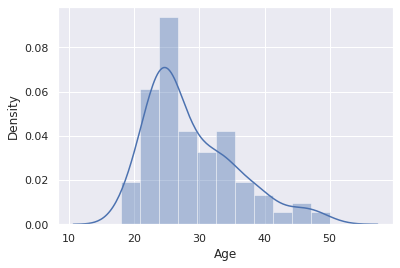

In [6]:
print(df['Age'].median())
sns.distplot(df['Age'])

Looks like the Age is normally distributed

Lets check the distribution of target variable

TM195    80
TM498    60
TM798    40
Name: Product, dtype: int64

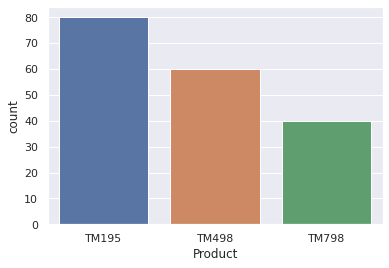

In [7]:
sns.countplot(df['Product'])
df['Product'].value_counts()

<AxesSubplot:>

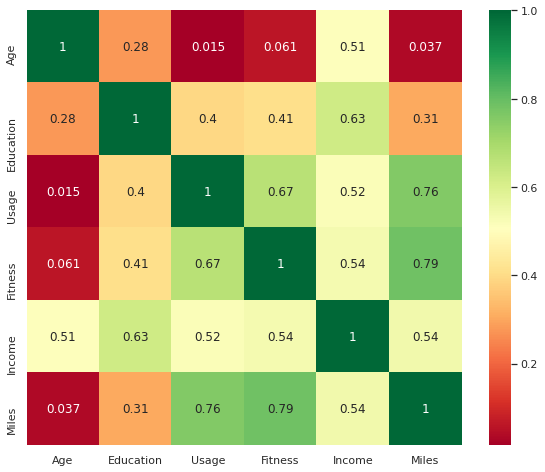

In [8]:
plt.figure(figsize=(10,8))
corr=df.corr()
sns.heatmap(corr,square=True,annot=True,cmap='RdYlGn')

In [9]:
df[['Product','Usage']].groupby(['Product'],as_index=False).median().sort_values(by='Product',ascending=False)

,Product,Usage
2,TM798,5
1,TM498,3
0,TM195,3


In [10]:
df[['Product','Fitness']].groupby(['Product'],as_index=False).median().sort_values(by='Product',ascending=False)

,Product,Fitness
2,TM798,5
1,TM498,3
0,TM195,3


In [11]:
print(df['Age'].min())
print(df['Age'].max())

18
50


<h3>Splitting the age into different groups</h3>

<h3>Feature Engineering</h3>
Lets do a bit of Feature Engineering.<br>In this simple scenario we will transform Age into different groups. 

In [12]:
category=pd.cut(df['Age'],bins=[17,26,42,50],labels=['Young','Middle','Senior'])
df.insert(3,'Age Group',category)

In [13]:
pd.crosstab(df['Product'],df['Age Group'])

Age Group,Young,Middle,Senior
Product,,,
TM195,41,34,5
TM498,31,27,2
TM798,19,18,3


<h3>Modelling the data</h3>

In [14]:
X=df.drop(['Product'],axis=1)
y=df['Product']

In [15]:
X=X.drop(['Age','Education'],axis=1)

<h3>Encoding categorical variables</h3>


In [16]:
import category_encoders as ce
encoder=ce.OrdinalEncoder(cols=['Gender','Age Group','MaritalStatus'],return_df=True,verbose=None)
X=encoder.fit_transform(X)

In [17]:
X.head()

,Gender,Age Group,MaritalStatus,Usage,Fitness,Income,Miles
0,1,1,1,3,4,29562,112
1,1,1,1,2,3,31836,75
2,2,1,2,4,3,30699,66
3,1,1,1,3,3,32973,85
4,1,1,2,4,2,35247,47


Changing the category of categorical variables

In [18]:
categorical_cols=['Gender','Age Group','MaritalStatus','Usage','Fitness']
for col in X[categorical_cols]:
    X[col]=X[col].astype('category')

In [19]:
X_train,X_val,y_train,y_val=train_test_split(X,y,test_size=0.1,random_state=42,shuffle=y)

In [20]:
print(X_train.shape)
print(X_val.shape)
print(y_train.shape)
print(y_val.shape)

(162, 7)
(18, 7)
(162,)
(18,)


<h3>Scaling the data</h3>

In [21]:
sc=StandardScaler()
ct=ColumnTransformer([('scaler',sc,[5,6])],remainder='passthrough')
X_train=ct.fit_transform(X_train)
X_val=ct.transform(X_val)

We have used column transformer here to scale the columns Income and Miles.

In [22]:
X_train=pd.DataFrame(X_train,columns=['Income','Miles','Gender','Age Group','MaritalStatus','Usage','Fitness'])

In [23]:
X_val=pd.DataFrame(X_val,columns=['Income','Miles','Gender','Age Group','MaritalStatus','Usage','Fitness'])

<h3>We have selected 3 models for our classification task</h3>
<ol>
<li>Logistic Regression</li>
<li>XGBoost</li>
<li>K Nearest Neighbours</li>
</ol>    

In [24]:
clf_log=LogisticRegression(C=0.1)
clf_log.fit(X_train,y_train)
log_y_preds=clf_log.predict(X_val)
print('Accuracy Score %0.2f'%(100*accuracy_score(y_val,log_y_preds)))
print(classification_report(y_val,log_y_preds))

Accuracy Score 72.22
              precision    recall  f1-score   support

       TM195       0.75      0.90      0.82        10
       TM498       0.33      0.25      0.29         4
       TM798       1.00      0.75      0.86         4

    accuracy                           0.72        18
   macro avg       0.69      0.63      0.65        18
weighted avg       0.71      0.72      0.71        18



We got a slightly decent 72%

In [25]:
xg_clf=XGBClassifier(n_estimators=120,learning_rate=0.1)
xg_clf.fit(X_train,y_train)
xg_y_preds=xg_clf.predict(X_val)
print('Accuracy Score %0.2f'%(100*accuracy_score(y_val,xg_y_preds)))
print(classification_report(y_val,log_y_preds))

[11:21:57] WARNING: ../src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
Accuracy Score 77.78
              precision    recall  f1-score   support

       TM195       0.75      0.90      0.82        10
       TM498       0.33      0.25      0.29         4
       TM798       1.00      0.75      0.86         4

    accuracy                           0.72        18
   macro avg       0.69      0.63      0.65        18
weighted avg       0.71      0.72      0.71        18



Wow! 6% bump up from logistic regression score

In [26]:
knn_clf=KNeighborsClassifier(n_neighbors=3)
knn_clf.fit(X_train,y_train)
knn_y_preds=knn_clf.predict(X_val)
print('Accuracy Score %0.2f'%(100*accuracy_score(y_val,knn_y_preds)))
print(classification_report(y_val,knn_y_preds))

Accuracy Score 55.56
              precision    recall  f1-score   support

       TM195       0.62      0.50      0.56        10
       TM498       0.29      0.50      0.36         4
       TM798       1.00      0.75      0.86         4

    accuracy                           0.56        18
   macro avg       0.64      0.58      0.59        18
weighted avg       0.63      0.56      0.58        18



XGBoost and KNN got a tie with both models getting the same accuracy score.<br>
We can further bump up the score by tuning hyperparameters.<br>
But lets not get into this

<h3>Lets try something new and model our data with ANN(Artificial Neural Network)</h3>

In [27]:
model=Sequential()
model.add(Dense(64,input_dim=(7),activation='relu'))
model.add(Dense(32,activation='relu'))
model.add(Dense(16,activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(3,activation='softmax'))
model.compile(loss='categorical_crossentropy',optimizer='rmsprop',metrics=['accuracy'])
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 64)                512       
_________________________________________________________________
dense_1 (Dense)              (None, 32)                2080      
_________________________________________________________________
dense_2 (Dense)              (None, 16)                528       
_________________________________________________________________
dropout (Dropout)            (None, 16)                0         
_________________________________________________________________
dense_3 (Dense)              (None, 3)                 51        
Total params: 3,171
Trainable params: 3,171
Non-trainable params: 0
_________________________________________________________________


In [28]:
y_train.value_counts()
product_code={'TM195':1,'TM498':2,'TM798':3}
y_train=y_train.map(product_code)
y_val=y_val.map(product_code)
y_train=pd.get_dummies(y_train)
y_val=pd.get_dummies(y_val)

In [29]:
print(y_train.shape)
print(y_val.shape)

(162, 3)
(18, 3)


In [30]:
model.fit(X_train,y_train,epochs=100,verbose=1)

Epoch 1/100
6/6 [==============================] - 1s 2ms/step - loss: 1.2409 - accuracy: 0.2632
Epoch 2/100
6/6 [==============================] - 0s 2ms/step - loss: 1.1101 - accuracy: 0.3525
Epoch 3/100
6/6 [==============================] - 0s 2ms/step - loss: 1.0715 - accuracy: 0.4096
Epoch 4/100
6/6 [==============================] - 0s 2ms/step - loss: 1.0461 - accuracy: 0.4513
Epoch 5/100
6/6 [==============================] - 0s 2ms/step - loss: 1.0454 - accuracy: 0.3789
Epoch 6/100
6/6 [==============================] - 0s 2ms/step - loss: 1.0267 - accuracy: 0.4493
Epoch 7/100
6/6 [==============================] - 0s 2ms/step - loss: 1.0271 - accuracy: 0.4743
Epoch 8/100
6/6 [==============================] - 0s 2ms/step - loss: 1.0062 - accuracy: 0.4873
Epoch 9/100
6/6 [==============================] - 0s 2ms/step - loss: 1.0165 - accuracy: 0.4983
Epoch 10/100
6/6 [==============================] - 0s 2ms/step - loss: 0.9892 - accuracy: 0.5150
Epoch 11/100
6/6 [===========

In [31]:
_,accuracy=model.evaluate(X_val,y_val)
print('Accuracy is {:0.2f}%'.format(100*accuracy))

1/1 [==============================] - 0s 167ms/step - loss: 0.5273 - accuracy: 0.7778
Accuracy is 77.78%


We got almost same accuracy as XGBoost and KNN.I feel this may be because of two reasons
* Not many features to find the pattern
* Not many samples to train

Please upvote if you find this kernel helpful.